# SAIRD
Applying the NEAT tecnique to the SAIRD model explained below

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class GSAIRD():
    
    def __init__(self, R0=2, alpha=0.07, gamma=0.3, eta=0.2, N=60e+6, A=1, 
                 report=False):
        self.N = N               # Total number of people
        self.A0 = A              # Initial asyntomatics
        self.R0 = R0
        self.A = A               # Asyntomatic
        self.I = 0               # Infective
        self.R = 0               # Recovered
        self.D = 0               # Dead
        self.S = self.N - self.I # Susceptible
        self.int_ter = 152e+3    # Places in intensive terapy in hospitals
        
        self.beta0 = R0*(gamma+eta) # Initial susc->asy rate
        self.alpha0 = alpha       # Initial asy->inf rate 1/incubation
        self.gamma0 = gamma       # Initial recovering rate
        self.eta0 = eta           # Initial inf->dead rate
        self.beta = R0*(gamma+eta)# Susc->asy rate
        self.alpha = alpha        # Asy->Inf rate
        self.gamma = gamma        # Inf->Rec rate
        self.eta = eta      # Inf->Dead rate
        self.chi = 0.05           # Knowing rate. The "system" knows only the worst
                                  # cases, 5%. Can be augmented with tests.
        self.old_chi = 0.05
        
        self.res_founds = 2       # Invest in research
        self.t_borders = 0        # Days from start of closure of borders
        self.t_quarantine = 0     # Days from start quarantine
        self.rew = 0              # Reward of the process
        self.num_ac = 11          # Number of possible actions from the system
        self.ac_report = np.zeros( self.num_ac )
        
        self.k = self.I*self.chi/self.N  # Known infected.
        self.O = [self.k, self.res_founds] # Observations known to the network
        self.report = report      # If true write on file the actions
        self.status = 'Running'   # Status of the system
        if self.report:
            self.writer = open('reporter.txt', 'w')
            self.evolution = [[alpha], [self.beta], [gamma], [eta], [self.chi] ]
            self.Ss = []
            self.As = []
            self.Is = []
            self.Rs = []
            self.Ds = []
        
    def reset(self):
        self.__init__(N=self.N, A=self.A0, R0=self.R0, gamma=self.gamma0,
                     alpha=self.alpha0, eta=self.eta0, report=self.report)
                
    def SAIRD(self):
        dS = -self.beta*self.S*self.A/self.N
        dA = self.beta*self.S*self.A/self.N  - self.alpha*self.A -self.gamma*self.A/4
        dI = self.alpha*self.A - self.gamma*self.I/2 - self.eta*self.I
        dR = self.gamma*self.I*3/4 + self.gamma*self.A/4
        dD = self.eta*self.I
        
        self.S += dS
        self.A += dA
        self.I += dI
        self.R += dR
        self.D += dD
        
        
    def action_sel(self, ac):
        index = ac.argmax()
        return index
    
    def ac0(self):
        """ Do nothing """
        self.ac_report[0] += 1
        
    def ac1(self):
        """ Use minor protection, like mask and washing hands. No "rage" from people. """
        if self.ac_report[1] == 0:
            self.beta *= 0.9              # Arbitrary, to be determine from data
        self.ac_report[1] += 1
        
    def ac2(self):
        """ Close country frontiers. Small rage from people. """
        if self.ac_report[2] == 0:
            self.beta *= 0.8
            self.ac_report[2] += 1
        
    def ac3(self):
        """ Remove block on frontiers. """
        if self.ac_report[2] == 1:
            self.beta /= 0.8
            self.ac_report[2] -= 1
            self.t_borders = 0
        self.ac_report[3] += 1
            
    def ac4(self):
        """ Quarantine. Medium rage from people. """
        if self.ac_report[4] == 0:
            self.beta *= 0.5
            self.ac_report[4] += 1
            
    def ac5(self):
        """ Remove quarantine. """
        if self.ac_report[4] == 1:
            self.beta /= 0.5
            self.ac_report[4] -= 1       
            self.t_quarantine = 0
        self.ac_report[5] += 1
        
    def ac6(self):
        """ Selective quarantine. """
        if self.ac_report[6] == 0:
            self.beta *= (1-self.chi)
            self.old_chi = self.chi
            self.ac_report[6] += 1
            
    def ac7(self):
        """ Remove selective quarantine. """
        if self.ac_report[6] == 1:
            self.ac_report[6] -= 1
            self.beta /= (1-self.old_chi)
        self.ac_report[7] += 1
        
    def ac8(self):
        """ Invest in research. """
        self.res_founds += 1
        self.ac_report[8] += 1
        
    def ac9(self):
        """ Spend founds in tests. """
        if self.res_founds >= 1:
            self.res_founds -= 1
            self.chi /= 0.9       # Increase number of people visible from the system
        self.ac_report[9] += 1
        
    def ac10(self):
        """ Spend founds in better cure. """
        if self.res_founds >= 1:
            self.res_founds -= 1
            self.gamma /= 0.9    # Increase number of recovered people
            self.eta *= 0.9      # Decrease the number of dead people
        self.ac_report[10] += 1
        
#    def ac11(self):
#        """ For greater good. """
#        self.I -= chi*self.I    # Kill all the known infects
#        self.rew -= 5
        
    def _reward(self):
        if self.S != 0:
            if self.ac_report[2] > 0: # Rage from closing the country
                self.rew -= (1.1 - np.exp(-0.005*self.t_borders) )
                self.t_borders += 1
            if self.ac_report[4] > 0: # Rage from quarantine
                self.rew -= (1.2 - np.exp(-0.01*self.t_quarantine) )
                self.t_quarantine += 1
            if self.I*0.05 >= self.int_ter: # hospital breakdown
                self.rew -= 10
            self.rew += 1 - (self.I+self.A+self.D)/self.N
            
            
    def _update(self, index):
        if   index == 0:  self.ac0()
        elif index == 1:  self.ac1() 
        elif index == 2:  self.ac2() 
        elif index == 3:  self.ac3() 
        elif index == 4:  self.ac4() 
        elif index == 5:  self.ac5() 
        elif index == 6:  self.ac6() 
        elif index == 7:  self.ac7() 
        elif index == 8:  self.ac8() 
        elif index == 9:  self.ac9() 
        elif index == 10: self.ac10() 
        #elif index == 11: self.ac11() 
        
    def _upd_obs(self):
        self.k = self.S*self.chi/self.N  # Known infected.
        self.O = [self.k, self.res_founds] # Observations known to the network
    
    def _report(self, index, num):
        self.ac_des = ['00) Do nothing. \n', 
                       '01) Use minor protection, like mask and washing hands. \n',
                       '02) Close country borders. \n',
                       '03) Remove block on borders. \n',
                       '04) Imposing quarantine. \n',
                       '05) Remove quarantine. \n',
                       '06) Impose quarantine only on known infected. \n',
                       '07) Remove selective quarantine. \n',
                       '08) Invest in research. \n',
                       '09) Spend research founds in test. \n',
                       '10) Spend research founds in searching for a cure. \n'#,
                      # '11) Kill all known infects. \n'
                      ]
        if num%3==0:
            self.writer.write(self.ac_des[index])
        self.evolution[0].append( self.alpha )
        self.evolution[1].append( self.beta )
        self.evolution[2].append( self.gamma )
        self.evolution[3].append( self.eta )
        self.evolution[4].append( self.chi )
        self.Ss.append( self.S/self.N)
        self.As.append( self.A/self.N)
        self.Is.append( self.I/self.N)
        self.Rs.append( self.R/self.N)
        self.Ds.append( self.D/self.N)
        
    def close_rep(self):
        if self.report:
            self.writer.close()
    
    def step(self, actions):
        index = self.action_sel(actions)
        self._update(index)
        for _ in range(3):
            self.SAIRD()
            self._reward()
            self._upd_obs()
            if self.report: self._report(index, _)
        if (self.A < 1 and self.I <1): self.status = 'Finished'
            

In [3]:
from SaveLoadNet import load_object, save_object
from visualize import draw_net
import neat
import os

config_file = os.path.join('.', './../Config/config_gestional.txt')
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_file)

In [4]:
env = GSAIRD(R0=2)

def eval_genomes(genomes, config):
    networks = [neat.nn.RecurrentNetwork.create(genome, config) for (genomeid, genome) in genomes]    
    obs = env.O
    rew = []
    
    env.reset()
    for net in networks:
        temp_rew = []
        for _ in range(10):
            for i in range(500):
                actions = np.array( net.activate(obs) )
                env.step(actions)
                obs = env.O
                if env.status == 'Finished': break    
            temp_rew.append( env.rew )
            env.reset()
        temp_rew = np.array(temp_rew)
        rew.append( temp_rew.mean() )
        
    for i, (genomeid, genome) in enumerate(genomes):
            genome.fitness = rew[i]


    env.reset()

In [5]:
p = neat.Population(config)
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
#p.add_reporter(neat.Checkpointer(5))
N_iter = 100
singol = p.run(eval_genomes, N_iter)                                           


 ****** Running generation 0 ****** 

Population's average fitness: -22.04488 stdev: 33.16645
Best fitness: 8.19668 - size: (12, 24) - species 2 - id 52
Average adjusted fitness: 0.738
Mean genetic distance 2.432, standard deviation 0.316
Population of 250 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   130    -22.3    0.735     0
     2    0   120    -21.7    0.741     0
Total extinctions: 0
Generation time: 9.594 sec

 ****** Running generation 1 ****** 

Population's average fitness: -11.89752 stdev: 24.46104
Best fitness: 7.46010 - size: (13, 20) - species 1 - id 369
Average adjusted fitness: 0.825
Mean genetic distance 2.372, standard deviation 0.287
Population of 250 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   206    -10.8    0.835     0
     2    1    44    -13.0    0.815     0
Total extinctions: 0
Generation time: 6.610 sec (8.102 

Population's average fitness: -17.98990 stdev: 31.91124
Best fitness: 24.40749 - size: (14, 8) - species 1 - id 3918
Average adjusted fitness: 0.673
Mean genetic distance 2.364, standard deviation 0.347
Population of 249 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   15   129    -13.7    0.701     3
     2   15    31    -19.0    0.660     3
     3   11    89    -19.1    0.659     8
Total extinctions: 0
Generation time: 5.540 sec (5.586 average)

 ****** Running generation 16 ****** 

Population's average fitness: -16.99452 stdev: 30.39265
Best fitness: 8.27179 - size: (12, 8) - species 3 - id 4105
Average adjusted fitness: 0.782
Mean genetic distance 2.560, standard deviation 0.441
Population of 249 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   16   106    -15.7    0.785     4
     2   16    38    -11.8    0.820     4
     3   12   103    -20.7    0.7

Population's average fitness: -7.03641 stdev: 20.79769
Best fitness: 48.55005 - size: (17, 12) - species 5 - id 7074
Average adjusted fitness: 0.637
Mean genetic distance 2.472, standard deviation 0.421
Population of 250 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   28    80     -3.1    0.660     4
     2   28    17     -3.9    0.655     0
     3   24    17     -5.6    0.643     1
     4   12    29    -13.7    0.590     6
     5   10    68     -5.4    0.645     1
     6    4    39     -7.4    0.631     1
Total extinctions: 0
Generation time: 5.146 sec (5.189 average)

 ****** Running generation 29 ****** 

Population's average fitness: -6.16996 stdev: 16.02191
Best fitness: 11.07581 - size: (15, 10) - species 1 - id 7486
Average adjusted fitness: 0.854
Mean genetic distance 2.534, standard deviation 0.455
Population of 251 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  ====

Population's average fitness: -8.92450 stdev: 25.94573
Best fitness: 8.19668 - size: (17, 4) - species 6 - id 10040
Average adjusted fitness: 0.828
Mean genetic distance 2.631, standard deviation 0.434
Population of 249 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   40    19     -5.5    0.877     5
     2   40    15     -2.9    0.900     1
     3   36   163    -11.9    0.820    11
     4   24    19    -22.4    0.725    18
     5   22    21    -14.1    0.800    13
     6   16    12     -8.7    0.848    13
Total extinctions: 0
Generation time: 5.429 sec (5.366 average)

 ****** Running generation 41 ****** 

Population's average fitness: -13.95702 stdev: 33.19174
Best fitness: 8.41366 - size: (17, 9) - species 6 - id 10389
Average adjusted fitness: 0.819
Mean genetic distance 2.646, standard deviation 0.451
Population of 250 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =====

Mean genetic distance 2.816, standard deviation 0.417
Population of 250 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   51    20    -26.4    0.688    16
     2   51    42      0.6    0.930     1
     5   33    61     -3.8    0.890     2
     6   27    20    -34.3    0.618     8
     7   10    39     -4.2    0.887     9
     8    7    44     -2.8    0.900     3
     9    6    24     -8.3    0.850     3
Total extinctions: 0
Generation time: 6.948 sec (5.666 average)

 ****** Running generation 52 ****** 

Population's average fitness: -5.09824 stdev: 20.18679
Best fitness: 8.19668 - size: (15, 4) - species 7 - id 13005
Average adjusted fitness: 0.873
Mean genetic distance 2.831, standard deviation 0.408
Population of 250 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   52    29     -4.7    0.884    17
     2   52    31     -4.2    0.889     2
     5   34   

Population's average fitness: -3.38792 stdev: 13.22616
Best fitness: 11.07581 - size: (15, 6) - species 9 - id 15935
Average adjusted fitness: 0.872
Mean genetic distance 2.811, standard deviation 0.504
Population of 251 members in 8 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     2   63    19     -5.6    0.855    13
     5   45    64     -1.7    0.888    14
     6   39    45     -1.0    0.894     6
     7   22    34     -0.3    0.901     4
     8   19    34      0.2    0.905     4
     9   18     7    -11.0    0.807     9
    10    8    17     -5.0    0.860     1
    11    4    31     -3.8    0.869     2
Total extinctions: 0
Generation time: 5.933 sec (6.244 average)

 ****** Running generation 64 ****** 

Population's average fitness: -1.97919 stdev: 13.01844
Best fitness: 8.41366 - size: (13, 9) - species 7 - id 16117
Average adjusted fitness: 0.892
Mean genetic distance 2.769, standard deviation 0.487
Population of 252 members in 8 

Population's average fitness: -1.74234 stdev: 10.22897
Best fitness: 8.19668 - size: (14, 7) - species 7 - id 18511

Species 9 with 29 members is stagnated: removing it
Average adjusted fitness: 0.898
Mean genetic distance 2.840, standard deviation 0.498
Population of 250 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     6   50    25     -0.3    0.922    17
     7   33    60     -0.3    0.923    15
     8   30    60     -3.2    0.896    15
    10   19    40     -0.4    0.921     2
    11   15    42     -2.4    0.903     1
    12    1    23    -11.2    0.823     0
Total extinctions: 0
Generation time: 4.864 sec (5.069 average)

 ****** Running generation 75 ****** 

Population's average fitness: -2.04752 stdev: 8.72866
Best fitness: 8.19668 - size: (21, 9) - species 7 - id 18783
Average adjusted fitness: 0.858
Mean genetic distance 2.801, standard deviation 0.479
Population of 251 members in 6 species:
   ID   age  size  fitne

Population's average fitness: -1.72577 stdev: 11.66782
Best fitness: 8.19668 - size: (16, 7) - species 7 - id 21769
Average adjusted fitness: 0.926
Mean genetic distance 2.851, standard deviation 0.485
Population of 249 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     7   46    42     -2.4    0.905    10
    10   32    40     -0.1    0.926    15
    11   28    66     -3.2    0.897    14
    12   14    62     -2.3    0.906     7
    13    7    29     -0.3    0.924     4
    14    1    10      7.8    0.996     0
Total extinctions: 0
Generation time: 4.968 sec (4.901 average)

 ****** Running generation 88 ****** 

Population's average fitness: -1.52864 stdev: 12.94421
Best fitness: 8.46885 - size: (17, 8) - species 12 - id 22143
Average adjusted fitness: 0.907
Mean genetic distance 2.837, standard deviation 0.542
Population of 248 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =====

Population's average fitness: -2.39295 stdev: 13.67943
Best fitness: 8.19668 - size: (16, 6) - species 15 - id 24760
Average adjusted fitness: 0.876
Mean genetic distance 2.810, standard deviation 0.541
Population of 250 members in 8 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    12   26    30      1.4    0.939    19
    13   19    29     -2.7    0.902     7
    14   13    48     -5.1    0.880    12
    15   11    78     -1.9    0.910     3
    16    5    27     -4.4    0.887     2
    17    5    13      1.0    0.936     3
    18    1    24    -27.7    0.678     0
    19    0     1       --       --     0
Total extinctions: 0
Generation time: 4.826 sec (4.966 average)

Best individual in generation 99 meets fitness threshold - complexity: (12, 9)


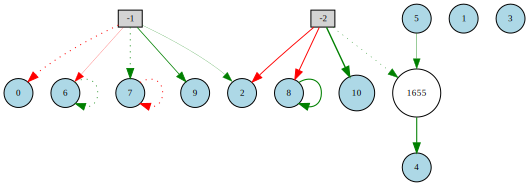

In [6]:
draw_net(config, singol)

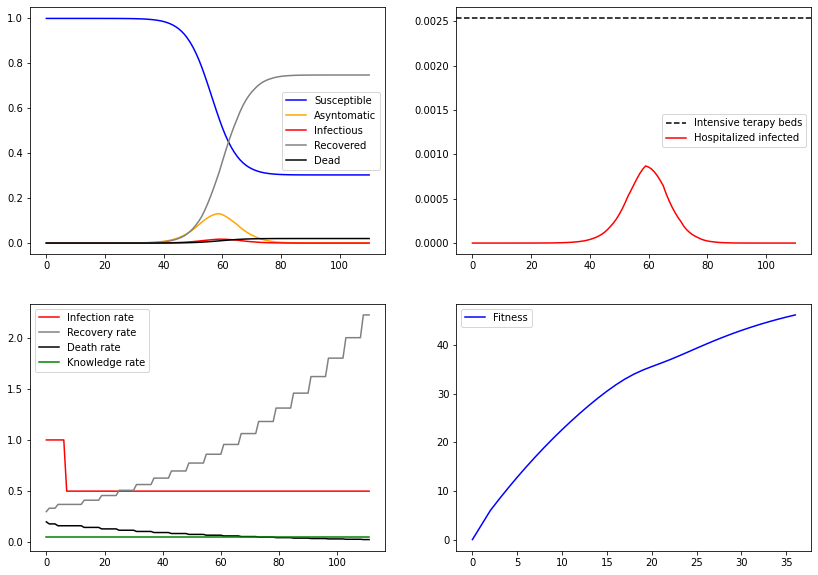

In [7]:
best_net = neat.nn.RecurrentNetwork.create(singol, config)
env = GSAIRD(report=True)
rew = []
obs = env.O

for i in range(500):
    rew.append( env.rew )
    actions = np.array( best_net.activate(obs) )
    env.step(actions)
    obs = env.O
    if env.status == 'Finished': break
env.close_rep()
        
S = np.array(env.Ss)
A = np.array(env.As)
R = np.array(env.Rs)
I = np.array(env.Is)
D = np.array(env.Ds)
ter = env.int_ter/env.N
        
fig, ax = plt.subplots(2, 2, figsize=(14,10) )
ax = ax.flatten()
ax[0].plot(S, color='blue', label= 'Susceptible')
ax[0].plot(A, color='orange', label= 'Asyntomatic')
ax[0].plot(I, color='red', label= 'Infectious')
ax[0].plot(R, color='gray', label= 'Recovered')
ax[0].plot(D, color='black', label= 'Dead')
ax[0].legend()

ax[1].axhline(ter, ls='--', color='black', label= 'Intensive terapy beds')
ax[1].plot(I*0.05, color='red', label='Hospitalized infected')
ax[1].legend()

ax[2].plot( env.evolution[1], color='red', label='Infection rate')
ax[2].plot( env.evolution[2], color='gray', label='Recovery rate')
ax[2].plot( env.evolution[3], color='black', label='Death rate')
ax[2].plot( env.evolution[4], color='green', label='Knowledge rate')
ax[2].legend()
#ax[2].set_xlim(0, 15)

ax[3].plot(rew, color='blue', label='Fitness')
ax[3].legend()

plt.show()

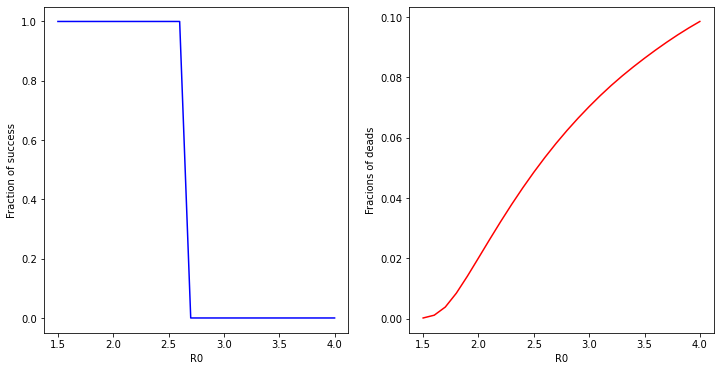

In [8]:
R0s = np.arange(1.5, 4.1, 0.1)
N = 100
success = np.zeros(len(R0s))
deads = np.zeros(len(R0s))
for i, r in enumerate(R0s):
    env = GSAIRD(report=True, R0=r)
    T=200
    dt=3
    for k in range(N):
        env.reset()
        obs = env.O
        for _ in range(T):
            actions = np.array( best_net.activate(obs) )
            env.step(actions)
            obs = env.O
            if env.status == 'Finished': break
        if max(env.Is)*0.05 < env.int_ter/env.N :
            success[i] += 1
        deads[i] += max(env.Ds)
deads /= N
success /= N

fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(R0s, success, color='blue')
ax[0].set_xlabel('R0')
ax[0].set_ylabel('Fraction of success')
ax[1].plot(R0s, deads, color='red')
ax[1].set_xlabel('R0')
ax[1].set_ylabel('Fracions of deads')
plt.show()

In [12]:
#save_object(singol, 'SIARD_argmax')

### Code to plot in LateX-friendly format

In [5]:
singol = load_object('SIARD_argmax')

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# Plotting LateX figures
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.facecolor'] = 'white'

In [7]:
best_net = neat.nn.RecurrentNetwork.create(singol, config)
env = GSAIRD(report=True)
rew = []
obs = env.O

for i in range(500):
    rew.append( env.rew )
    actions = np.array( best_net.activate(obs) )
    env.step(actions)
    obs = env.O
    if env.status == 'Finished': break
env.close_rep()
        
S = np.array(env.Ss)
A = np.array(env.As)
R = np.array(env.Rs)
I = np.array(env.Is)
D = np.array(env.Ds)
ter = env.int_ter/env.N
        
fig, ax = plt.subplots(2, 2, figsize=(4.3,3) )
ax = ax.flatten()
ax[0].plot(S, color='blue', label= 'S')
ax[0].plot(A, color='orange', label= 'A')
ax[0].plot(I, color='red', label= 'I')
ax[0].plot(R, color='gray', label= 'R')
ax[0].plot(D, color='black', label= 'D')
ax[0].legend()
ax[0].set_ylabel('Population')

ax[1].axhline(ter, ls='--', color='black', label= 'Max beds')
ax[1].plot(I*0.05, color='red', label='Serious infected')
ax[1].legend()

ax[2].plot( env.evolution[1], color='red', label='bs')
ax[2].plot( env.evolution[2], color='gray', label='gs')
ax[2].plot( env.evolution[3], color='black', label='es')
ax[2].plot( env.evolution[4], color='green', label='cs')
ax[2].legend(loc=4)
ax[2].set_ylabel('Rate')
ax[2].set_xlabel('Time [days]')
#ax[2].set_xlim(0, 15)

ax[3].plot(rew, color='blue', label='Fitness')
ax[3].set_ylabel('Fitness')
ax[3].set_xlabel('Time [days]')
ax[3].legend()

if max(I*0.05) > env.int_ter/env.N: print('Not good')
plt.tight_layout()
plt.savefig('evol_SAIRD.pgf', facecolor=(1,1,1,0))
plt.close()

In [8]:
R0s = np.arange(1.5, 4.1, 0.1)
N = 100
success = np.zeros(len(R0s))
deads = np.zeros(len(R0s))
for i, r in enumerate(R0s):
    env = GSAIRD(report=True, R0=r)
    T=200
    dt=3
    for k in range(N):
        env.reset()
        obs = env.O
        for _ in range(T):
            actions = np.array( best_net.activate(obs) )
            env.step(actions)
            obs = env.O
            if env.status == 'Finished': break
        if max(env.Is)*0.05 < env.int_ter/env.N :
            success[i] += 1
        deads[i] += max(env.Ds)
deads /= N
success /= N

fig, ax = plt.subplots( figsize=(4.3, 2))
ax.plot(R0s, success, color='blue')
ax.set_xlabel('R0')
ax.set_ylabel('Fraction of success')
plt.tight_layout()
plt.savefig('SAIRD_success.pgf', facecolor=(1,1,1,0))